# Insert Title Here
**DATA102 S11 Group 3*
- Banzon, Beatrice Elaine B.
- Buitre, Cameron
- Marcelo, Andrea Jean C.
- Navarro, Alyssa Riantha R.
- Vicente, Francheska Josefa

# **Requirements and Imports**
Before starting, the relevant libraries and files in building and training the model should be loaded into the notebook first.

## **Basic** Libraries
* `numpy` contains a large collection of mathematical functions
* `pandas` contains functions that are designed for data manipulation and data analysis

In [51]:
import numpy as np
import pandas as pd

## **`Natural Language Processing`** Libraries
* `train_test_split` is a function that allows the dataset to be split into two randomly.
* `TFidfVectorizer` converts the given text documents into a matrix, which has TF-IDF features
* `CountVectorizer` converts the given text documents into a matrix, which has the counts of the tokens

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

## **`Machine Learning`** Libraries
The following classes are models that implement different methods of clustering or classification.
- `KMeans` is a class under the cluster models module that implements k-means clustering.
- `LogisticRegression` is a class under the linear models module that implements regularized logistic regression

In [53]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

Next is the `shuffle` function which shuffles matrices and arrays.

In [54]:
from sklearn.utils import shuffle

On the other hand, these classes computes and visualizes the different scores about how well a model works.
* `f1_score` computes the balanced F-score by comparing the actual classes and the predicted classes
* `hamming_loss` computes the fraction of labels that were incorrectly labeled by the model
* `accuracy_score` computes the accuracy by determining how many classes were correctly predicted
* `precision_recall_fscore_support`computes the precision, recall, F-measure and support per class
* `ConfusionMatrixDisplay` allows the visualization of the computed confusion matrix
* `confusion_matrix`  is a function that displays the number of samples that are correctly and incorrectly labeled by the model, by grouping them into four groups (i.e., True Positives, False Positives, True Negatives, False Negatives)

In [55]:
from sklearn.metrics import f1_score, roc_auc_score, hamming_loss, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [56]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

Meanwhile, `GridSearchCV` is a cross-validation class that allows the exhaustive search over all possible combinations of hyperparameter values

In [57]:
from sklearn.model_selection import GridSearchCV

Last, `pickle` is a module that can serialize and deserialize objects. In this notebook, it is used to save and load models.

In [58]:
import pickle

### Datasets and Files
To train the models that utilizes the traditional machine learning algorithms, the dataset that was cleaned will be loaded using the [`read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function.

In [59]:
df = pd.read_csv ('cleaned_data.csv')
df

,label,text
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...
...,...,...
24035,0,The winner of the special election in Cavite t...
24036,0,The remains of four people inside the Cessna p...
24037,0,A Kabataan Party-list representative visited t...
24038,0,The Philippine Coast Guard is expected to have...


# **Feature Engineering**

As we cannot directly feed the text data as input to the machine learning models, we have to convert it into the format that they can understand—numbers. Before doing that, since we want to save the models and vectorizers that we will be using, we will first need to define the values and functions to do so, starting with the folder where we will be saving it. 

In [60]:
main_directory = './saved_models/Clustering/vectorizers/'

Next, we will be creating a function that will be saving the vectorizer to the specified path.

In [61]:
def save_vectorizers (vectorizer, vectorizer_name):
    vectorizer_filename = main_directory + vectorizer_name + '.pkl'
    
    with open(vectorizer_filename, 'wb') as file:
        pickle.dump(vectorizer, file)

## Splitting the Dataset into **`Train`**, **`Validation`**, and **`Test`** Split
Let us first define the **X** (input) and **y** (target/output) of our model. This is done to allow the stratifying of the data when it is split into the train, val and test.

The **X** (input) can be retrieved by getting the `text` column in the original dataset.

In [62]:
X = df ['text']
X

0        Ayon sa TheWrap.com, naghain ng kaso si Krupa,...
1        Kilala rin ang singer sa pagkumpas ng kanyang ...
2        BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma...
3        Kasama sa programa ang pananalangin, bulaklak ...
4        Linisin ang Friendship Department dahil dadala...
                               ...                        
24035    The winner of the special election in Cavite t...
24036    The remains of four people inside the Cessna p...
24037    A Kabataan Party-list representative visited t...
24038    The Philippine Coast Guard is expected to have...
24039    National Bureau of Investigation-National Capi...
Name: text, Length: 24040, dtype: object

Meanwhile, the **y** value (i.e., the value that we would be "feeding" our models) is the `label` column. 

In [63]:
y = df ['label']
y

0        0
1        0
2        0
3        0
4        0
        ..
24035    0
24036    0
24037    0
24038    0
24039    0
Name: label, Length: 24040, dtype: int64

Now that we have declared the input and the target output of our models, we can use the [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to divide the dataset into two splits. Some things to note are: (1) the split is stratified based on the **y values**, (2) the value of the random state was set to 42 for reproducibility, and (3) the dataset is shuffled.

First, let us create the train and test set. The test set is made up of 20% of the original dataset, which infers that the second split is 80% of the original. 

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 42, 
                                                    shuffle = True)

Second, we will be splitting the remaining 80% of the original dataset into two: the train and val sets. The train set will be 90% of the second split, while the val set will be 10% of it. 

In [65]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size = 0.1,
                                                  stratify = y_train,
                                                  random_state = 42, 
                                                  shuffle = True)

However, since we want to test if deciding the `class` of the prediction based on the dominant class of the points in a cluster is enough, we want to make sure that the train dataset has equal number of instances for each of the class.  To do this, we created a function that would ensure that the number of positive and negative instances are equal.

In [66]:
def make_dataframe (df):
    true_df = df [df ['label'] == 1][['text', 'label']]
    false_df = df [df ['label'] == 0][['text', 'label']]
    
    num_of_true = len(true_df)
    
    false_df = false_df.sample(n = num_of_true)
    false_df = false_df.reset_index(drop=True)
    
    df = false_df.append(true_df, ignore_index = True)
    df = shuffle(df.reset_index(drop=True)).reset_index(drop=True)
    
    return df

To easily divide the train set, let us first [`concat`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html)enate the X_train and y_train into one DataFrame. In addition to this, to ensure that the index of the DataFrame is sequential, we would be using the [`reset_index`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html) function. 

In [67]:
train_df = pd.concat([X_train, y_train], axis = 1).reset_index(drop = True)
train_df

,text,label
0,Makabayan bloc lawmakers at the House of Repre...,0
1,WASHINGTON - The World Bank is ready to do its...,0
2,Corporate Army smashes Dakota barbarians near ...,1
3,Cyber War - From Trifle to Catastrophe By Ern...,1
4,"KYIV, Ukraine - International Atomic Energy Ag...",0
...,...,...
17303,Nagsalita na rin sa wakas si Pangulong Rodrigo...,1
17304,"Canada's most populous province, Ontario, said...",0
17305,Matatandaang nag-ugat ang lahat sa loob ng Ceb...,0
17306,Posible nang mabalikan at muling maranasan bil...,0


Using the combined DataFrame, we would be creating a DataFrame that has equal number of positive and negative instances.

In [68]:
train_df = make_dataframe (train_df)
train_df

C:\Users\User\AppData\Local\Temp\ipykernel_6148\1097446513.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = false_df.append(true_df, ignore_index = True)


,text,label
0,As Republicans jockey for their party’s top sp...,0
1,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,1
2,Share This \r\nVice Admiral Kevin Donegan toda...,1
3,The Philippine National Police (PNP) on Wednes...,0
4,"Now 68, Bacevich is a West Point graduate who ...",0
...,...,...
6723,"NAIA AIRPORT , BUKOD SA PAPALITAN NA NG PANGAL...",1
6724,Makabayan bloc lawmakers at the House of Repre...,0
6725,President Rodrigo Duterte on Tuesday renewed h...,0
6726,The Senate committee on foreign relations on W...,0


As we have changed the train dataset, we would be re-declaring the values for the X and y of the train dataset.

In [69]:
X_train = train_df ['text']
y_train = train_df ['label']

For consistency, we would also be [`concat`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html)enating the validation set.

In [70]:
val_df = pd.concat([X_val, y_val], axis = 1).reset_index(drop = True)
val_df

,text,label
0,The Cuban flag is flying over the Cuban Embass...,0
1,Tatlong mananaya ang masuwerteng nanalo sa mag...,0
2,"BEIJING/MOSCOW — China, Iran and Russia are co...",0
3,The Donald Trump campaign is counting on “unde...,0
4,LONDON — Britain is supplying Ukraine with Sto...,0
...,...,...
1919,The son of Justice Secretary Jesus Crispin Rem...,0
1920,"A magnitude 5 quake struck Socorro, Surigao de...",0
1921,By Amanda Froelich These ‘before and after’ ph...,1
1922,Infectious diseases expert Dr. Rontgene Solant...,0


And lastly, the test set would also be [`concat`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html)enated into one DataFrame.

In [71]:
test_df = pd.concat([X_test, y_test], axis = 1).reset_index(drop = True)
test_df

,text,label
0,"CEBU, Philippines – The men who abducted devel...",0
1,"MANILA, Philippines – A United States-based th...",0
2,"President Ferdinand ""Bongbong"" Marcos, Jr.'s c...",0
3,Senator Cynthia Villar on Tuesday accused Sena...,0
4,DCG | 2 Comments \r\nRules are for little pe...,1
...,...,...
4803,Long lines of commuters snaked down streets in...,0
4804,London is kidding itself if it thinks this wil...,0
4805,U-M’s New ‘Chief Diversity Officer’ Will Colle...,1
4806,Several foreign ambassadors have expressed the...,0


To check if the shapes of the input and output are the same, we will be looking at the shapes of the resulting DataFrame.


In [72]:
print('Train')
print('Input  shape: ', X_train.shape)
print('Output shape: ', y_train.shape, '\n')

print('Val')
print('Input  shape: ', X_val.shape)
print('Output shape: ', y_val.shape, '\n')

print('Test')
print('Input  shape: ', X_test.shape)
print('Output shape: ', y_test.shape, '\n') 

Train
Input  shape:  (6728,)
Output shape:  (6728,) 

Val
Input  shape:  (1924,)
Output shape:  (1924,) 

Test
Input  shape:  (4808,)
Output shape:  (4808,) 



## Tokenizing with **`TF-IDF` Vectorizer**

Now, we can proceed with tokenizing our input. To do this, we first create an instance of a [`TF-IDF Vectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) with english stopwords as its list of stopwords and a maximum feature of 5000.

In [73]:
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 5000)

### **`Train`** Data
With the created vectorizer, we can now use the [`fit_transform`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.fit_transform) function, which will learn the vocabulary and the inverse document frequency from the data provided, and then create a document-term matrix using the same data.

In [74]:
tfidf_train = tfidf_vectorizer.fit_transform(X_train.values.astype('U'))

To use this vectorizer that has learned from the vocabulary, let us save it using the function we previously defined. 

In [75]:
save_vectorizers(tfidf_vectorizer, 'tfidf')

### **`Validation`** Data
Using the [`transform`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.transform) function, we will be creating a document-term matrix for the validation set. For this, it is important to convert the datatype of the values in the validation set into **Unicode**, as this is the type accepted by the function.

In [76]:
tfidf_val = tfidf_vectorizer.transform(X_val.values.astype('U'))

### **`Test`** Data
Next, we will also [`transform`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.transform) our test data into a document-term matrix, and to do this, we also have to convert it into the **Unicode** datatype.

In [77]:
tfidf_test = tfidf_vectorizer.transform(X_test.values.astype('U'))

## Tokenizing with **`Count` Vectorizer**

We create a [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) object, with the same parameter values as the [`TF-IDF Vectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

In [78]:
count_vectorizer = CountVectorizer(stop_words = 'english', max_features = 5000)

In [79]:
count_train = count_vectorizer.fit_transform(X_train.values.astype('U'))
save_vectorizers(count_vectorizer, 'count')

In [80]:
count_val = count_vectorizer.transform(X_val.values.astype('U'))

In [81]:
count_test = count_vectorizer.transform(X_test.values.astype('U'))

# Modeling and Evaluation
Now that we have transformed our data into the format that our algorithms can understand, we can move on to the modeling proper.

## Defining the **Functions**
To start with, let us first define the functions and the values needed to easily train the model. First, we would be creating a function that would convert the cluster number of the points into a prediction of 0 or 1 (i.e,. news or fake news). 

In [82]:
def convert_to_label (prediction, labels_per_cluster):
    return labels_per_cluster [prediction]

Next, we will be creating a function that will call the functions for the metrics (i.e., [`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html), [`f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), [`hamming_loss`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hamming_loss.html), and [`precision_recall_fscore_support`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)) that are used for the scoring. 

In [83]:
def scores (y_true, y_pred):
    accuracy = accuracy_score(y_true = y_true, y_pred = y_pred)   
    f1_micro_average = f1_score(y_true = y_true, y_pred = y_pred, average = 'micro')
    f1_macro_average = f1_score(y_true = y_true, y_pred = y_pred, average = 'macro')
    hamming_loss_score = hamming_loss(y_true = y_true, y_pred = y_pred)
    precision, recall, _, _ = precision_recall_fscore_support(y_true, y_pred, average = 'weighted')
    
    return accuracy, f1_micro_average, f1_macro_average, hamming_loss_score, precision, recall

To be able to view the scores in a readable format, we also created a function that would create a dictionary out of the scores.

In [84]:
def format_scores (k, y_true, y_pred):
    accuracy, f1_micro_average, f1_macro_average, hamming_loss_score, precision, recall = scores (y_true, y_pred)
    
    return {
        'K' : k,
        'Accuracy' : accuracy,
        'F1 Micro Average' : f1_micro_average,
        'F1 Macro Average' : f1_macro_average,
        'Hamming Loss' : hamming_loss_score,
        'Precision' : precision,
        'Recall' : recall,
    }

Next, since we would be experimenting on two ways to predict using clusters (i.e., predicting by looking at the dominant class per cluster, and using the cluster number as additional information in a Logistic Regresion model), we would be defining functions that could do the clustering and prediction in these two ways.

The `cluster_categorize_predict` is the function that would be used for the latter process. In this function, there are four major steps: (1) the points are clustered by the trained K-means clustering model, (2) the predictions are appended to the dataset, (3) the Logistic Regression model was used to predict the resulting DataFrame (i.e., the one where the clusters were appended into), and (4) the score of the model was computed.

In [85]:
def cluster_categorize_predict (k, orig_df, df_set, km, model, vectorizer):
    predictions = km.predict (df_set)
    converted_df = pd.DataFrame(df_set.toarray(), columns = vectorizer.get_feature_names_out())
    
    labeled_df = orig_df.copy() 
    labeled_df ['predictions'] = predictions 
    
    temp_x = pd.concat ([converted_df, labeled_df ['predictions']], axis = 1)
    
    predictions = model.predict (temp_x.values)
    
    dict_scores = format_scores (k, labeled_df ['label'], val_predictions)
    
    return dict_scores

Then, the `cluster_then_categorize_news` function is used to: (1) train the model that is used for k-means clustering, (2) predict on the train data using the k-means, (3) concatenate the cluster result of the k-means model to the vectorized matrix, (4) train the Logistic Regression model using the resulting matrix, and (5) predict on the test set by calling `cluster_categorize_predict`.

In [86]:
def cluster_then_categorize_news (k, train_set, val_set, model, vectorizer):
    label_per_cluster = {}
    
    km = KMeans (n_clusters = k, random_state = 42)
    km.fit (train_set)
    train_predictions = km.predict (train_set)
    converted_train = pd.DataFrame(train_set.toarray(), columns = vectorizer.get_feature_names_out())
    
    train_labeled_df = train_df.copy() 
    train_labeled_df ['predictions'] = train_predictions
    
    temp_x_train = pd.concat ([converted_train, train_labeled_df ['predictions']], axis = 1)

    model.fit (temp_x_train.values, y_train)

    dict_scores = cluster_categorize_predict (k, val_df, val_set, km, model, vectorizer)
        
    return dict_scores, km, model

Last, the `cluster_news` function is used for the former process of predicting using the cluster. In this, instead of using the cluster number as an additional feature for the Logistic Regression model, it just converts the cluster number to the dominant class per cluster. 

In [87]:
def cluster_news (k, train_set, val_set):
    label_per_cluster = {}
    
    km = KMeans (n_clusters = k, random_state = 42)
    km.fit (train_set)
    train_predictions = km.predict (train_set)
    train_labeled_df = train_df.copy() 
    train_labeled_df ['predictions'] = train_predictions

    for i in range (k + 1):
        dominant_label = train_labeled_df.groupby ('predictions')[['label']].value_counts().index [i][1]
        label_per_cluster [i] = dominant_label
    
    train_labeled_df ['predictions'] = train_labeled_df ['predictions'].replace(labels_per_cluster)

    dict_scores = format_scores (k, train_labeled_df ['label'], train_labeled_df ['predictions'])

    val_predictions = km.predict (val_set)
    val_labeled_df = val_df.copy() 
    val_labeled_df ['predictions'] = val_predictions 
    val_labeled_df ['predictions'] = val_labeled_df ['predictions'].replace(labels_per_cluster)

    dict_scores = format_scores (k, val_labeled_df ['label'], val_labeled_df ['predictions'])
        
    return dict_scores, km, label_per_cluster

## K-means (TF-IDF Vectorizer)
With all of the relevant functions declared, we can now proceed with the actual training proper.

For the first model, we would be using the resulting matrix from the [`TF-IDF Vectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to train the k-means model. The resulting clusters would determine the class of the text by getting the dominant class in a cluster.

To do this, we will first declare a dictionary that would hold the dominant class per cluster number.

In [88]:
labels_per_cluster = {}

To be able to find the best k-value for the model, we would be creating a list that would hold the scores of the each of the value of the k.

In [89]:
tfidf_val_scores = []

In addition to the scores, we would have to create a list of k-means model and the list of dictionaries that would allow us to use the best model for prediction.

In [90]:
tfidf_models = []
tfidf_labels_per_cluster = []

With these, we can start training k-means clustering models with different k valuesusing the `cluster_news` function. This would allow us to determine which k-value would result in the highest validation score. 

In [91]:
for k in range (1, 60):
    val_score, model, label = cluster_news (k, tfidf_train, tfidf_val)
    tfidf_val_scores.append (val_score)
    tfidf_models.append (model)
    tfidf_labels_per_cluster.append (label)

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classif

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245:

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245:

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245:

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245:

With the training of the models finished, we can now look at the DataFrame of their validation scores. Using the [`sort_values`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html) function, we would be sorting the scores of the model in descending order by the **F1 Macro Average**, which is the main metric for our models. In addition, the index of the DataFrame would be resetted using the [`reset_index`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html) function—to ensure that model with the highest F1 Macro Score is at the index 0 of the DataFrame.

In [101]:
scores_df = pd.DataFrame (tfidf_val_scores)
scores_df = scores_df.sort_values ('F1 Macro Average', ascending = False)
scores_df = scores_df.reset_index (drop = True)
scores_df

,K,Accuracy,F1 Micro Average,F1 Macro Average,Hamming Loss,Precision,Recall
0,2,0.689709,0.689709,0.547345,0.310291,0.718177,0.689709
1,1,0.805613,0.805613,0.446172,0.194387,0.649013,0.805613
2,4,0.221414,0.221414,0.160374,0.778586,0.670971,0.221414
3,6,0.342516,0.342516,0.128274,0.657484,0.927961,0.342516
4,7,0.362266,0.362266,0.122313,0.637734,0.903557,0.362266
5,3,0.148649,0.148649,0.113596,0.851351,0.491466,0.148649
6,9,0.331081,0.331081,0.094422,0.668919,0.869386,0.331081
7,5,0.077443,0.077443,0.065649,0.922557,0.344289,0.077443
8,10,0.185551,0.185551,0.060015,0.814449,0.867097,0.185551
9,8,0.084719,0.084719,0.049958,0.915281,0.808027,0.084719


Since we have sorted the scores in descending order by the F1 Macro Score, we are confident that the topmost score belongs to the model with the highest F1 Macro Score. Thus, we can get the **K** value of this first row. After getting the K-value with the highest F1 Score, we can subtract one from it to retrieve the index of our model in the list of models that we have.

In [102]:
best_model_index = int (scores_df.loc [0]['K']) - 1
best_model_index

1

With this retrieved model, we can predict on the validation set to test if the score we previously received will be the same.

In [103]:
val_predictions = tfidf_models [best_model_index].predict (tfidf_val)
val_labeled_df = val_df.copy() 
val_labeled_df ['predictions'] = val_predictions 
val_labeled_df ['predictions'] = val_labeled_df ['predictions'].replace(tfidf_labels_per_cluster [best_model_index])

With the predicted classes of the text, we will be computing for the score for each of the metrics.

In [105]:
dict_scores = format_scores (best_model_index + 1, val_labeled_df ['label'], val_labeled_df ['predictions'])
pd.DataFrame (dict_scores, index = [0])

,K,Accuracy,F1 Micro Average,F1 Macro Average,Hamming Loss,Precision,Recall
0,2,0.689709,0.689709,0.547345,0.310291,0.718177,0.689709


Since the score for the validation set remains the same, we can continue with the prediction on the test set using the k-means model, and then translating the cluster number to the predicted class by determining the dominant class for the cluster based on the count. 

In [106]:
test_predictions = tfidf_models [best_model_index].predict (tfidf_test)
test_labeled_df = test_df.copy() 
test_labeled_df ['predictions'] = test_predictions 
test_labeled_df ['predictions'] = test_labeled_df ['predictions'].replace(tfidf_labels_per_cluster [best_model_index])

With these predictions, the scores would be computed and formatted.

In [108]:
dict_scores = format_scores (best_model_index + 1, test_labeled_df ['label'], test_labeled_df ['predictions'])
pd.DataFrame (dict_scores, index = [0])

,K,Accuracy,F1 Micro Average,F1 Macro Average,Hamming Loss,Precision,Recall
0,2,0.694884,0.694884,0.547973,0.305116,0.71792,0.694884


To further analyze on where the model's error usually happens, we would be displaying its [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) through the use of the [`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)

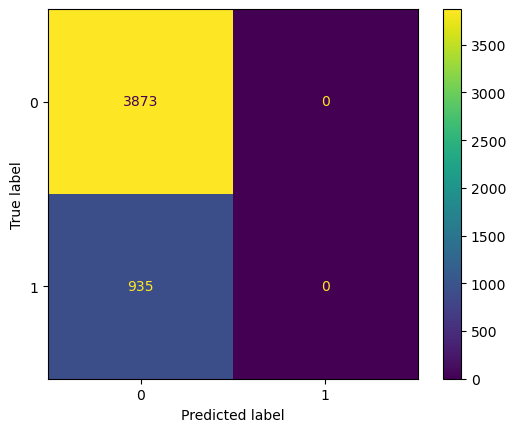

In [98]:
ConfusionMatrixDisplay(confusion_matrix(test_labeled_df ['label'], test_labeled_df ['predictions'])).plot()

From this [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html), we can see that the model just predicts all classes as negative. 

## K-means (Count Vectorizer)
For our second model, we would be using the same process as the first model—however, its main difference would be is that this would be utilizing the matrix that resulted from using the [`Count Vectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

As previously done, we would first be declaring a lists that would be storing three different things: (1) the score of each of the model, (2) the trained k-means models, and (3) the dictionary that would be used to convert the cluster numbers to the predictions.

In [109]:
count_val_scores = []
count_models = []
count_labels_per_cluster = []

With these, we can start training k-means clustering models with different k values using the `cluster_news` function. This would allow us to determine which k-value would result in the highest validation score. 

In [110]:
for k in range (1, 60):
    val_score, model, label = cluster_news (k, count_train, count_val)
    count_val_scores.append (val_score)
    count_models.append (model)
    count_labels_per_cluster.append (label)

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classif

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245:

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245:

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245:

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245:

Like previously, we would be turning the scores into a DataFrame to see it more easily. Additionally, we would be using a combination of the [`sort_values`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html) and [`reset_index`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html) functions in order to ensure that the model with the highest F1 Macro Score would be on index 0.

In [111]:
scores_df = pd.DataFrame (count_val_scores)
scores_df = scores_df.sort_values ('F1 Macro Average', ascending = False)
scores_df = scores_df.reset_index (drop = True)
scores_df

,K,Accuracy,F1 Micro Average,F1 Macro Average,Hamming Loss,Precision,Recall
0,2,0.722453,0.722453,0.563948,0.277547,0.726913,0.722453
1,1,0.805613,0.805613,0.446172,0.194387,0.649013,0.805613
2,9,0.597713,0.597713,0.186208,0.402287,0.739024,0.597713
3,3,0.163721,0.163721,0.156133,0.836279,0.637138,0.163721
4,10,0.263514,0.263514,0.097530,0.736486,0.852134,0.263514
5,6,0.222453,0.222453,0.096306,0.777547,0.627503,0.222453
6,11,0.231289,0.231289,0.078368,0.768711,0.843470,0.231289
7,4,0.059771,0.059771,0.076058,0.940229,0.058520,0.059771
8,8,0.153326,0.153326,0.070747,0.846674,0.558768,0.153326
9,13,0.379938,0.379938,0.069062,0.620062,0.671241,0.379938


We would also be initializing a variable that would be holding the index of the model that has the best value for the F1 Macro Score.

In [112]:
best_model_index = int (scores_df.loc [0]['K']) - 1
best_model_index

With us knowing the index of the model in our list of models, we can now use this model to predict on our validation set for testing purposes.

In [113]:
val_predictions = count_models [best_model_index].predict (count_val)
val_labeled_df = val_df.copy() 
val_labeled_df ['predictions'] = val_predictions 
val_labeled_df ['predictions'] = val_labeled_df ['predictions'].replace(count_val_scores [best_model_index])

In [114]:
dict_scores = format_scores (best_model_index + 1, val_labeled_df ['label'], val_labeled_df ['predictions'])
pd.DataFrame (dict_scores, index = [0])

,K,Accuracy,F1 Micro Average,F1 Macro Average,Hamming Loss,Precision,Recall
0,2,0.722453,0.722453,0.563948,0.277547,0.726913,0.722453


In [115]:
test_predictions = count_models [best_model_index].predict (count_test)
test_labeled_df = test_df.copy() 
test_labeled_df ['predictions'] = test_predictions 
test_labeled_df ['predictions'] = test_labeled_df ['predictions'].replace(count_labels_per_cluster [best_model_index])

In [116]:
dict_scores = format_scores (best_model_index + 1, test_labeled_df ['label'], test_labeled_df ['predictions'])
pd.DataFrame (dict_scores, index = [0])

,K,Accuracy,F1 Micro Average,F1 Macro Average,Hamming Loss,Precision,Recall
0,2,0.726705,0.726705,0.560265,0.273295,0.724477,0.726705


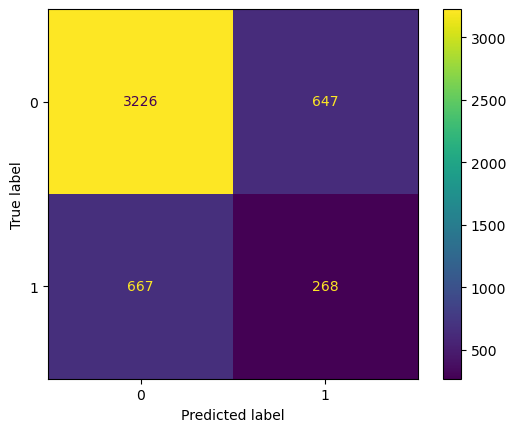

In [117]:
ConfusionMatrixDisplay(confusion_matrix(test_labeled_df ['label'], test_labeled_df ['predictions'])).plot()

## K-means and Logistic Regression (TF-IDF Vectorizer)

In [118]:
tfidf_logreg_models = []
tfidf_logreg_km_models = []
tfidf_logreg_scores = []

In [ ]:
for k in range (1, 60):
    logreg_model = LogisticRegression ()
    val_score, km, model = cluster_then_categorize_news (k, count_train, count_val, logreg_model, tfidf_vectorizer)
    tfidf_logreg_scores.append (val_score)
    tfidf_logreg_models.append (model)
    tfidf_logreg_km_models.append (km)

In [ ]:
scores_df = pd.DataFrame (tfidf_logreg_scores)
scores_df = scores_df.sort_values ('F1 Macro Average', ascending = False)
scores_df = scores_df.reset_index (drop = True)
scores_df

In [ ]:
best_model_index = int (scores_df.loc [0]['K']) - 1
best_model_index

In [ ]:
dict_scores = cluster_categorize_predict (best_model_index + 1, 
                                          test_df, tfidf_test, 
                                          tfidf_logreg_km_models [best_model_index],
                                          tfidf_logreg_models [best_model_index], tfidf_vectorizer)

In [ ]:
test_predictions = tfidf_logreg_models [best_model_index].predict (tfidf_test)
test_labeled_df = test_df.copy() 
test_labeled_df ['predictions'] = test_predictions 
test_labeled_df ['predictions'] = test_labeled_df ['predictions'].replace(count_labels_per_cluster [best_model_index])

In [ ]:
dict_scores = format_scores (best_model_index + 1, test_labeled_df ['label'], test_labeled_df ['predictions'])
pd.DataFrame (dict_scores, index = [0])

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(test_labeled_df ['label'], test_labeled_df ['predictions'])).plot()